**Home Credit Indonesia - Credit Risk Modeling**

# Import Library & Setup

In [ ]:
from google.colab import drive
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate, RandomizedSearchCV, cross_val_predict
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score,
    average_precision_score, precision_recall_curve, precision_score,
    recall_score, f1_score, roc_curve
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb

from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

from statsmodels.stats.outliers_influence import variance_inflation_factor


from imblearn.combine import SMOTEENN
from imblearn.pipeline import Pipeline as ImbPipeline

In [ ]:
# Mount Google Drive
drive.mount('/content/drive')
base_path = "/content/drive/My Drive/Home Credit Indonesia/"

Mounted at /content/drive


# Load Dataset

## Application Train (Tabel Utama)

In [ ]:
app_cols = [
    'SK_ID_CURR','TARGET','CODE_GENDER','DAYS_BIRTH','NAME_EDUCATION_TYPE',
    'NAME_FAMILY_STATUS','CNT_CHILDREN','AMT_INCOME_TOTAL','AMT_CREDIT',
    'AMT_ANNUITY','AMT_GOODS_PRICE','DAYS_EMPLOYED', 'OCCUPATION_TYPE', 'CNT_FAM_MEMBERS',
    'EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3'
]
application_train = pd.read_csv(base_path + "application_train.csv", usecols=app_cols)

## Bureau

In [ ]:
bureau_cols = [
    'SK_ID_BUREAU','SK_ID_CURR','CREDIT_ACTIVE','DAYS_CREDIT',
    'CREDIT_DAY_OVERDUE','AMT_CREDIT_SUM','AMT_CREDIT_SUM_DEBT', 'AMT_CREDIT_MAX_OVERDUE', 'AMT_CREDIT_SUM_OVERDUE'
]
bureau = pd.read_csv(base_path + "bureau.csv", usecols=bureau_cols)

## Bureau Balance

In [ ]:
bb_cols = [
    'SK_ID_BUREAU','MONTHS_BALANCE','STATUS'
]
bureau_balance = pd.read_csv(base_path + "bureau_balance.csv", usecols=bb_cols)

## Previous Application

In [ ]:
prev_cols = [
    'SK_ID_CURR','AMT_CREDIT','AMT_ANNUITY','NAME_CONTRACT_STATUS','DAYS_DECISION','NAME_CONTRACT_TYPE','NAME_GOODS_CATEGORY','CNT_PAYMENT','NAME_CLIENT_TYPE','CHANNEL_TYPE'
]
previous_application = pd.read_csv(base_path + "previous_application.csv", usecols=prev_cols)

## Installments Payments

In [ ]:
inst_cols = [
    'SK_ID_CURR','AMT_INSTALMENT','AMT_PAYMENT','DAYS_ENTRY_PAYMENT'
]
installments_payments = pd.read_csv(base_path + "installments_payments.csv", usecols=inst_cols)

## Credit Card Balance

In [ ]:
cc_cols = [
    'SK_ID_CURR','AMT_BALANCE','AMT_CREDIT_LIMIT_ACTUAL',
    'AMT_DRAWINGS_CURRENT','SK_DPD'
]
credit_card_balance = pd.read_csv(base_path + "credit_card_balance.csv", usecols=cc_cols)

## POS_CASH Balance

In [ ]:
pos_cols = [
    'SK_ID_CURR','MONTHS_BALANCE','SK_DPD'
]
pos_cash = pd.read_csv(base_path + "POS_CASH_balance.csv", usecols=pos_cols)

# Data Exploration

## Cek Ukuran Dataset

In [ ]:
print("Application Train:", application_train.shape)
print("Bureau:", bureau.shape)
print("Bureau Balance:", bureau_balance.shape)
print("Previous Application:", previous_application.shape)
print("Installments:", installments_payments.shape)
print("Credit Card Balance:", credit_card_balance.shape)
print("POS_CASH Balance:", pos_cash.shape)

Application Train: (307511, 17)
Bureau: (1716428, 9)
Bureau Balance: (27299925, 3)
Previous Application: (1670214, 10)
Installments: (13605401, 4)
Credit Card Balance: (3840312, 5)
POS_CASH Balance: (10001358, 3)


## Informasi & Preview Data

In [ ]:
ap_copy = application_train.copy()

In [ ]:
application_train.head()

,SK_ID_CURR,TARGET,CODE_GENDER,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,DAYS_BIRTH,DAYS_EMPLOYED,OCCUPATION_TYPE,CNT_FAM_MEMBERS,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3
0,100002,1,M,0,202500.0,406597.5,24700.5,351000.0,Secondary / secondary special,Single / not married,-9461,-637,Laborers,1.0,0.083037,0.262949,0.139376
1,100003,0,F,0,270000.0,1293502.5,35698.5,1129500.0,Higher education,Married,-16765,-1188,Core staff,2.0,0.311267,0.622246,NaN
2,100004,0,M,0,67500.0,135000.0,6750.0,135000.0,Secondary / secondary special,Single / not married,-19046,-225,Laborers,1.0,NaN,0.555912,0.729567
3,100006,0,F,0,135000.0,312682.5,29686.5,297000.0,Secondary / secondary special,Civil marriage,-19005,-3039,Laborers,2.0,NaN,0.650442,NaN
4,100007,0,M,0,121500.0,513000.0,21865.5,513000.0,Secondary / secondary special,Single / not married,-19932,-3038,Core staff,1.0,NaN,0.322738,NaN


In [ ]:
application_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Data columns (total 17 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   SK_ID_CURR           307511 non-null  int64  
 1   TARGET               307511 non-null  int64  
 2   CODE_GENDER          307511 non-null  object 
 3   CNT_CHILDREN         307511 non-null  int64  
 4   AMT_INCOME_TOTAL     307511 non-null  float64
 5   AMT_CREDIT           307511 non-null  float64
 6   AMT_ANNUITY          307499 non-null  float64
 7   AMT_GOODS_PRICE      307233 non-null  float64
 8   NAME_EDUCATION_TYPE  307511 non-null  object 
 9   NAME_FAMILY_STATUS   307511 non-null  object 
 10  DAYS_BIRTH           307511 non-null  int64  
 11  DAYS_EMPLOYED        307511 non-null  int64  
 12  OCCUPATION_TYPE      211120 non-null  object 
 13  CNT_FAM_MEMBERS      307509 non-null  float64
 14  EXT_SOURCE_1         134133 non-null  float64
 15  EXT_SOURCE_2     

In [ ]:
bureau.head()

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,DAYS_CREDIT,CREDIT_DAY_OVERDUE,AMT_CREDIT_MAX_OVERDUE,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_OVERDUE
0,215354,5714462,Closed,-497,0,NaN,91323.0,0.0,0.0
1,215354,5714463,Active,-208,0,NaN,225000.0,171342.0,0.0
2,215354,5714464,Active,-203,0,NaN,464323.5,NaN,0.0
3,215354,5714465,Active,-203,0,NaN,90000.0,NaN,0.0
4,215354,5714466,Active,-629,0,77674.5,2700000.0,NaN,0.0


In [ ]:
bureau.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1716428 entries, 0 to 1716427
Data columns (total 9 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   SK_ID_CURR              int64  
 1   SK_ID_BUREAU            int64  
 2   CREDIT_ACTIVE           object 
 3   DAYS_CREDIT             int64  
 4   CREDIT_DAY_OVERDUE      int64  
 5   AMT_CREDIT_MAX_OVERDUE  float64
 6   AMT_CREDIT_SUM          float64
 7   AMT_CREDIT_SUM_DEBT     float64
 8   AMT_CREDIT_SUM_OVERDUE  float64
dtypes: float64(4), int64(4), object(1)
memory usage: 117.9+ MB


In [ ]:
bureau_balance.head()

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C
3,5715448,-3,C
4,5715448,-4,C


In [ ]:
bureau_balance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27299925 entries, 0 to 27299924
Data columns (total 3 columns):
 #   Column          Dtype 
---  ------          ----- 
 0   SK_ID_BUREAU    int64 
 1   MONTHS_BALANCE  int64 
 2   STATUS          object
dtypes: int64(2), object(1)
memory usage: 624.8+ MB


In [ ]:
installments_payments.head()

,SK_ID_CURR,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,161674,-1187.0,6948.360,6948.360
1,151639,-2156.0,1716.525,1716.525
2,193053,-63.0,25425.000,25425.000
3,199697,-2426.0,24350.130,24350.130
4,167756,-1366.0,2165.040,2160.585


In [ ]:
installments_payments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13605401 entries, 0 to 13605400
Data columns (total 4 columns):
 #   Column              Dtype  
---  ------              -----  
 0   SK_ID_CURR          int64  
 1   DAYS_ENTRY_PAYMENT  float64
 2   AMT_INSTALMENT      float64
 3   AMT_PAYMENT         float64
dtypes: float64(3), int64(1)
memory usage: 415.2 MB


In [ ]:
previous_application.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_CREDIT,NAME_CONTRACT_STATUS,DAYS_DECISION,NAME_CLIENT_TYPE,NAME_GOODS_CATEGORY,CHANNEL_TYPE,CNT_PAYMENT
0,271877,Consumer loans,1730.430,17145.0,Approved,-73,Repeater,Mobile,Country-wide,12.0
1,108129,Cash loans,25188.615,679671.0,Approved,-164,Repeater,XNA,Contact center,36.0
2,122040,Cash loans,15060.735,136444.5,Approved,-301,Repeater,XNA,Credit and cash offices,12.0
3,176158,Cash loans,47041.335,470790.0,Approved,-512,Repeater,XNA,Credit and cash offices,12.0
4,202054,Cash loans,31924.395,404055.0,Refused,-781,Repeater,XNA,Credit and cash offices,24.0


In [ ]:
previous_application.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1670214 entries, 0 to 1670213
Data columns (total 10 columns):
 #   Column                Non-Null Count    Dtype  
---  ------                --------------    -----  
 0   SK_ID_CURR            1670214 non-null  int64  
 1   NAME_CONTRACT_TYPE    1670214 non-null  object 
 2   AMT_ANNUITY           1297979 non-null  float64
 3   AMT_CREDIT            1670213 non-null  float64
 4   NAME_CONTRACT_STATUS  1670214 non-null  object 
 5   DAYS_DECISION         1670214 non-null  int64  
 6   NAME_CLIENT_TYPE      1670214 non-null  object 
 7   NAME_GOODS_CATEGORY   1670214 non-null  object 
 8   CHANNEL_TYPE          1670214 non-null  object 
 9   CNT_PAYMENT           1297984 non-null  float64
dtypes: float64(3), int64(2), object(5)
memory usage: 127.4+ MB


In [ ]:
credit_card_balance.head()

,SK_ID_CURR,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_CURRENT,SK_DPD
0,378907,56.970,135000,877.5,0
1,363914,63975.555,45000,2250.0,0
2,371185,31815.225,450000,0.0,0
3,337855,236572.110,225000,2250.0,0
4,126868,453919.455,450000,11547.0,0


In [ ]:
credit_card_balance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3840312 entries, 0 to 3840311
Data columns (total 5 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   SK_ID_CURR               int64  
 1   AMT_BALANCE              float64
 2   AMT_CREDIT_LIMIT_ACTUAL  int64  
 3   AMT_DRAWINGS_CURRENT     float64
 4   SK_DPD                   int64  
dtypes: float64(2), int64(3)
memory usage: 146.5 MB


In [ ]:
pos_cash.head()

,SK_ID_CURR,MONTHS_BALANCE,SK_DPD
0,182943,-31,0
1,367990,-33,0
2,397406,-32,0
3,269225,-35,0
4,334279,-35,0


In [ ]:
pos_cash.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10001358 entries, 0 to 10001357
Data columns (total 3 columns):
 #   Column          Dtype
---  ------          -----
 0   SK_ID_CURR      int64
 1   MONTHS_BALANCE  int64
 2   SK_DPD          int64
dtypes: int64(3)
memory usage: 228.9 MB


In [ ]:
print("\nTARGET distribution:")
print(application_train['TARGET'].value_counts())
print((application_train['TARGET'].value_counts(normalize=True)*100).round(2))


TARGET distribution:
TARGET
0    282686
1     24825
Name: count, dtype: int64
TARGET
0    91.93
1     8.07
Name: proportion, dtype: float64


## Insight Di Awal

### Jenis Pekerjaan yang membayar tepat waktu

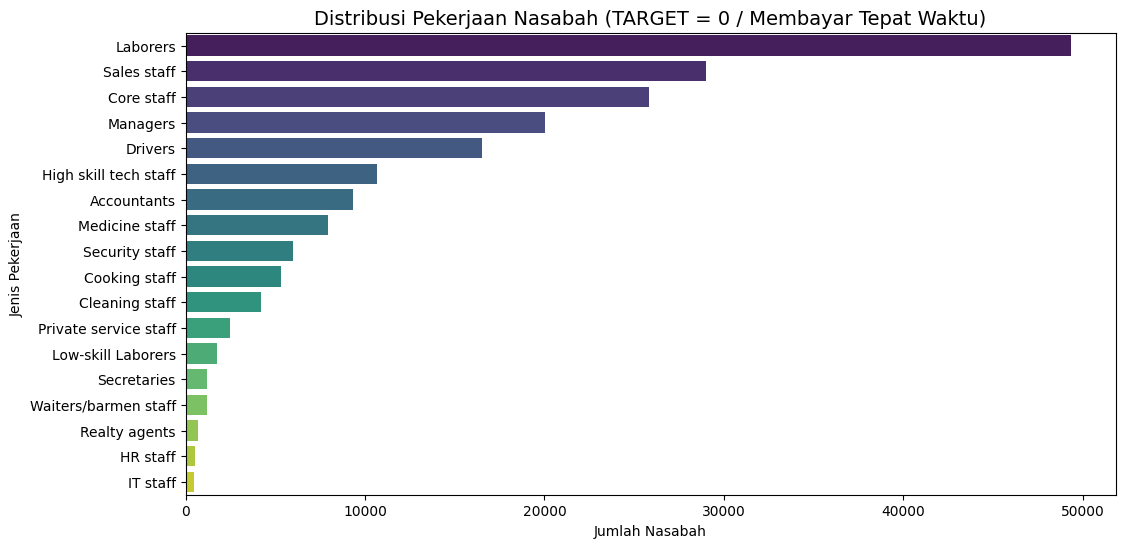

In [ ]:
on_time = ap_copy[ap_copy["TARGET"] == 0]
# Plot distribusi pekerjaan
plt.figure(figsize=(12,6))
sns.countplot(y="OCCUPATION_TYPE", data=on_time, order=on_time["OCCUPATION_TYPE"].value_counts().index, palette="viridis")

plt.title("Distribusi Pekerjaan Nasabah (TARGET = 0 / Membayar Tepat Waktu)", fontsize=14)
plt.xlabel("Jumlah Nasabah")
plt.ylabel("Jenis Pekerjaan")
plt.show()

### Usia Nasabah (TARGET=0)

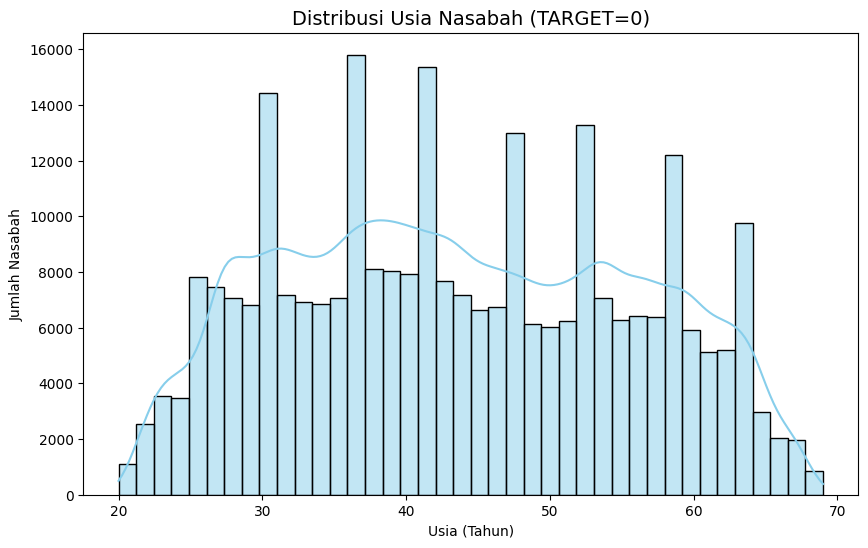

In [ ]:
# Hitung umur dari DAYS_BIRTH (nilai aslinya negatif → hari sebelum sekarang)
ap_copy["AGE"] = (-ap_copy["DAYS_BIRTH"] / 365).astype(int)

# Filter hanya TARGET=0
on_time = ap_copy[ap_copy["TARGET"] == 0]

# Plot distribusi umur
plt.figure(figsize=(10,6))
sns.histplot(on_time["AGE"], bins=40, kde=True, color="skyblue")
plt.title("Distribusi Usia Nasabah (TARGET=0)", fontsize=14)
plt.xlabel("Usia (Tahun)")
plt.ylabel("Jumlah Nasabah")
plt.show()

### Tingkat Pendidikan (TARGET=0)

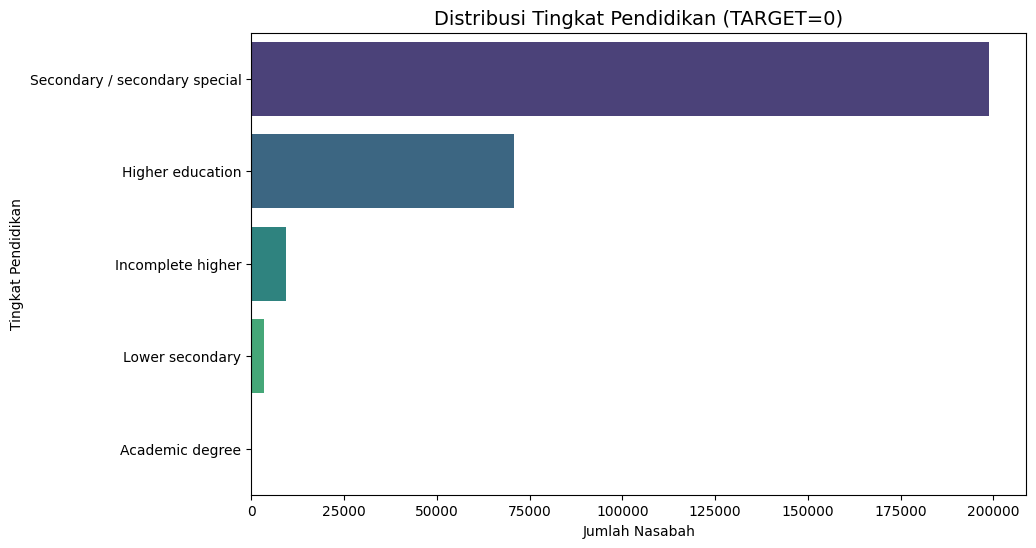

In [ ]:
# Filter TARGET=0
on_time = ap_copy[ap_copy["TARGET"] == 0]

plt.figure(figsize=(10,6))
sns.countplot(y="NAME_EDUCATION_TYPE", data=on_time,
              order=on_time["NAME_EDUCATION_TYPE"].value_counts().index,
              palette="viridis")
plt.title("Distribusi Tingkat Pendidikan (TARGET=0)", fontsize=14)
plt.xlabel("Jumlah Nasabah")
plt.ylabel("Tingkat Pendidikan")
plt.show()

### Tepat Waktu VS Gagal Bayar

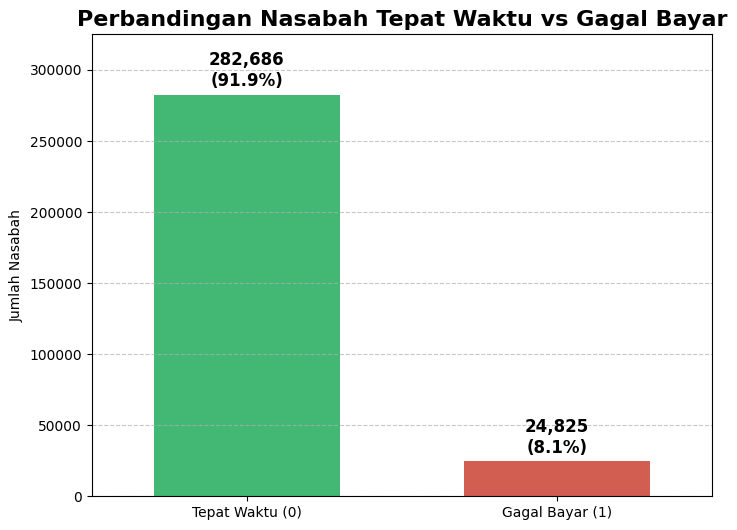

In [ ]:
# Hitung jumlah nasabah
target_counts = ap_copy["TARGET"].value_counts().sort_index()
labels = ["Tepat Waktu (0)", "Gagal Bayar (1)"]

plt.figure(figsize=(8,6))
ax = sns.barplot(x=labels, y=target_counts.values, palette=["#2ecc71","#e74c3c"], width=0.6)

# Tambah label angka & persentase
total = target_counts.sum()
for i, val in enumerate(target_counts.values):
    ax.text(i, val + (0.01*total),   # posisinya tepat di atas bar
            f"{val:,}\n({val/total:.1%})",
            ha='center', va='bottom',
            fontsize=12, fontweight="bold")

# Biar label gak kepotong
ax.set_ylim(0, max(target_counts.values) * 1.15)

plt.title("Perbandingan Nasabah Tepat Waktu vs Gagal Bayar", fontsize=16, fontweight="bold")
plt.ylabel("Jumlah Nasabah")
plt.xlabel("")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

#  Data Cleaning

## Perbaikan Tipe Data

In [ ]:
cat_cols = ['CODE_GENDER','NAME_EDUCATION_TYPE','NAME_FAMILY_STATUS']
for col in cat_cols:
    application_train[col] = application_train[col].astype('category')

if 'CREDIT_ACTIVE' in bureau.columns:
    bureau['CREDIT_ACTIVE'] = bureau['CREDIT_ACTIVE'].astype('category')

if 'NAME_CONTRACT_STATUS' in previous_application.columns:
    previous_application['NAME_CONTRACT_STATUS'] = previous_application['NAME_CONTRACT_STATUS'].astype('category')

if 'STATUS' in bureau_balance.columns:
    bureau_balance['STATUS'] = bureau_balance['STATUS'].astype('category')

## Missing Value Handling

In [ ]:
from sklearn.impute import SimpleImputer

def handle_missing(df, name="dataframe"):
    print(f"\n Missing Value Report: {name}")
    mis_val = df.isnull().sum()
    mis_val_percent = 100 * mis_val / len(df)
    mis_table = pd.concat([mis_val, mis_val_percent], axis=1)
    mis_table.columns = ["Missing Values", "% of Total Values"]
    mis_table = mis_table[mis_table["Missing Values"] > 0].sort_values("% of Total Values", ascending=False)
    print(mis_table)

    # Drop kolom > 20% missing
    drop_cols = mis_table[mis_table["% of Total Values"] > 20].index
    if len(drop_cols) > 0:
        print(f"Dropping columns (>{20}% missing): {list(drop_cols)}")
        df = df.drop(columns=drop_cols)

    # Imputasi kolom <= 20% missing
    num_imputer = SimpleImputer(strategy="median")
    cat_imputer = SimpleImputer(strategy="most_frequent")

    for col in df.columns:
        if df[col].isnull().sum() > 0:
            if df[col].dtype in [np.float64, np.int64]:
                df[col] = num_imputer.fit_transform(df[[col]])
            else:
                df[col] = cat_imputer.fit_transform(df[[col]])

    return df

In [ ]:
application_train = handle_missing(application_train, "Application Train")
bureau = handle_missing(bureau, "Bureau")
bureau_balance = handle_missing(bureau_balance, "Bureau Balance")
previous_application = handle_missing(previous_application, "Previous Application")
installments_payments = handle_missing(installments_payments, "Installments Payments")
credit_card_balance = handle_missing(credit_card_balance, "Credit Card Balance")
pos_cash = handle_missing(pos_cash, "POS_CASH Balance")


 Missing Value Report: Application Train
                 Missing Values  % of Total Values
EXT_SOURCE_1             173378          56.381073
OCCUPATION_TYPE           96391          31.345545
EXT_SOURCE_3              60965          19.825307
EXT_SOURCE_2                660           0.214626
AMT_GOODS_PRICE             278           0.090403
AMT_ANNUITY                  12           0.003902
CNT_FAM_MEMBERS               2           0.000650
Dropping columns (>20% missing): ['EXT_SOURCE_1', 'OCCUPATION_TYPE']

 Missing Value Report: Bureau
                        Missing Values  % of Total Values
AMT_CREDIT_MAX_OVERDUE         1124488          65.513264
AMT_CREDIT_SUM_DEBT             257669          15.011932
AMT_CREDIT_SUM                      13           0.000757
Dropping columns (>20% missing): ['AMT_CREDIT_MAX_OVERDUE']

 Missing Value Report: Bureau Balance
Empty DataFrame
Columns: [Missing Values, % of Total Values]
Index: []

 Missing Value Report: Previous Application
   

## Duplicate Check

In [ ]:
def handle_duplicates(df, name="dataframe"):
    dup_count = df.duplicated().sum()
    print(f"{name}: Found {dup_count} duplicate rows.")
    if dup_count > 0:
        df = df.drop_duplicates()
        print(f"{name}: Dropped {dup_count} duplicate rows. New shape: {df.shape}")
    return df

In [ ]:
application_train = handle_duplicates(application_train, "Application Train")
bureau = handle_duplicates(bureau, "Bureau")
bureau_balance = handle_duplicates(bureau_balance, "Bureau Balance")
previous_application = handle_duplicates(previous_application, "Previous Application")
installments_payments = handle_duplicates(installments_payments, "Installments Payments")
credit_card_balance = handle_duplicates(credit_card_balance, "Credit Card Balance")
pos_cash = handle_duplicates(pos_cash, "POS_CASH Balance")

Application Train: Found 0 duplicate rows.
Bureau: Found 0 duplicate rows.
Bureau Balance: Found 0 duplicate rows.
Previous Application: Found 82495 duplicate rows.
Previous Application: Dropped 82495 duplicate rows. New shape: (1587719, 8)
Installments Payments: Found 269418 duplicate rows.
Installments Payments: Dropped 269418 duplicate rows. New shape: (13335983, 4)
Credit Card Balance: Found 2012184 duplicate rows.
Credit Card Balance: Dropped 2012184 duplicate rows. New shape: (1828128, 5)
POS_CASH Balance: Found 1373061 duplicate rows.
POS_CASH Balance: Dropped 1373061 duplicate rows. New shape: (8628297, 3)


## Outlier Treatment

In [ ]:
def treat_outliers(df, cols, name="dataframe"):
    print(f"\nOutlier Treatment: {name}")
    for col in cols:
        if col in df.columns:
            # Simpan nilai asli untuk visualisasi before
            original = df[col].copy()

            # Hitung IQR
            Q1 = original.quantile(0.25)
            Q3 = original.quantile(0.75)
            IQR = Q3 - Q1
            lower = Q1 - 1.5 * IQR
            upper = Q3 + 1.5 * IQR

            # Hitung jumlah outlier sebelum
            outliers = ((original < lower) | (original > upper)).sum()
            print(f"{col}: Found {outliers} outliers")

            # Winsorizing (clip ke batas bawah & atas)
            df[col] = np.clip(original, lower, upper)

            # Plot before & after samping-sampingan
            fig, axes = plt.subplots(1, 2, figsize=(10,3))
            sns.boxplot(x=original, ax=axes[0])
            axes[0].set_title(f"{col} - Before")

            sns.boxplot(x=df[col], ax=axes[1])
            axes[1].set_title(f"{col} - After")

            plt.suptitle(f"Outlier Treatment ({name}) - {col}", fontsize=12, y=1.05)
            plt.tight_layout()
            plt.show()

    return df


Outlier Treatment: Application Train
AMT_INCOME_TOTAL: Found 14035 outliers


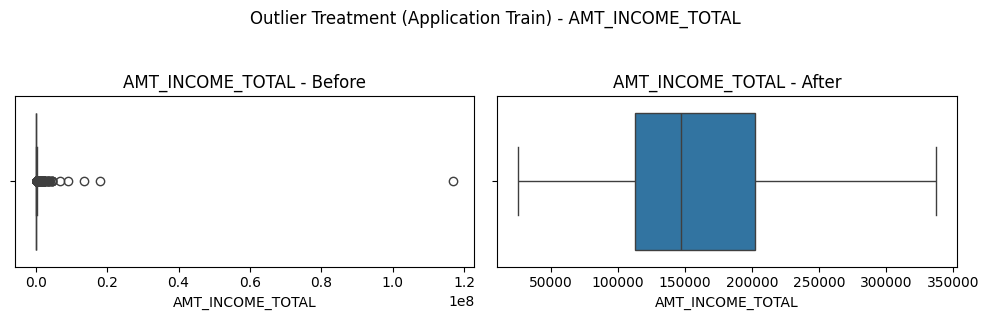

AMT_CREDIT: Found 6562 outliers


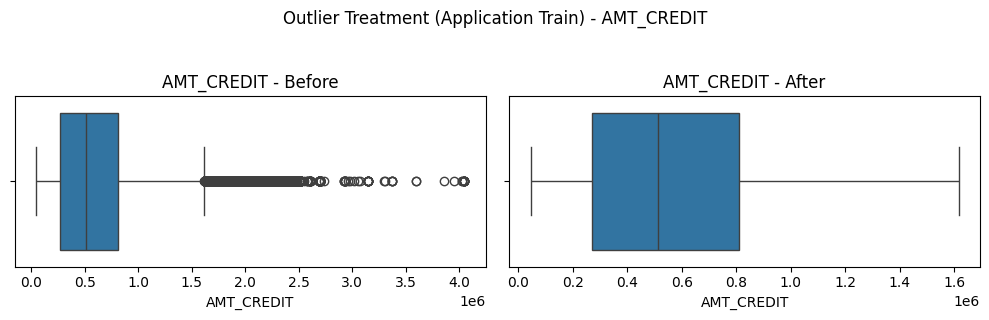

AMT_ANNUITY: Found 7504 outliers


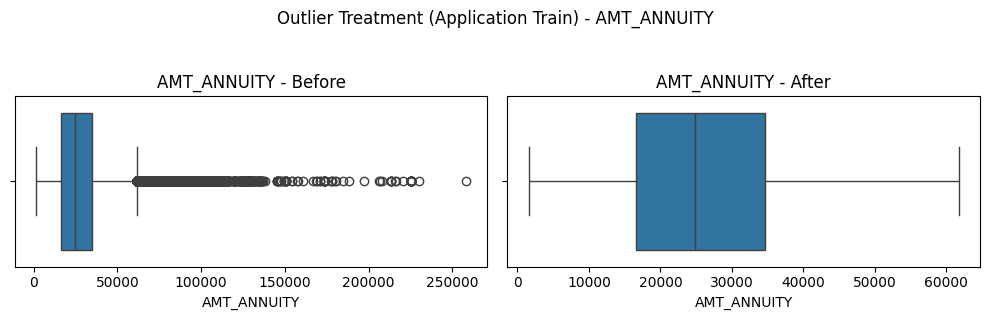

AMT_GOODS_PRICE: Found 14728 outliers


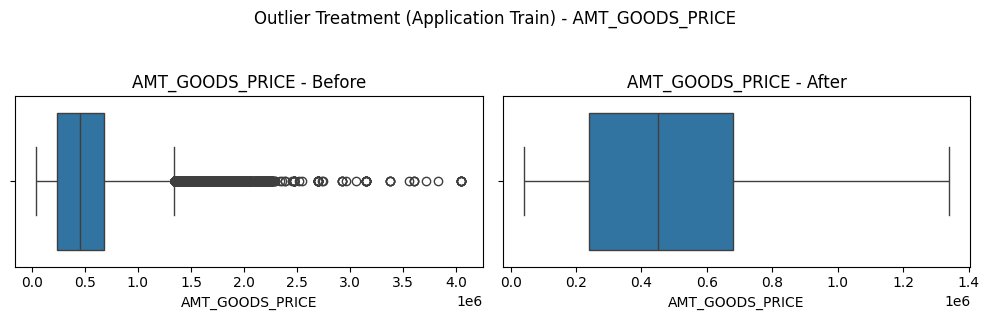

DAYS_EMPLOYED: Found 72217 outliers


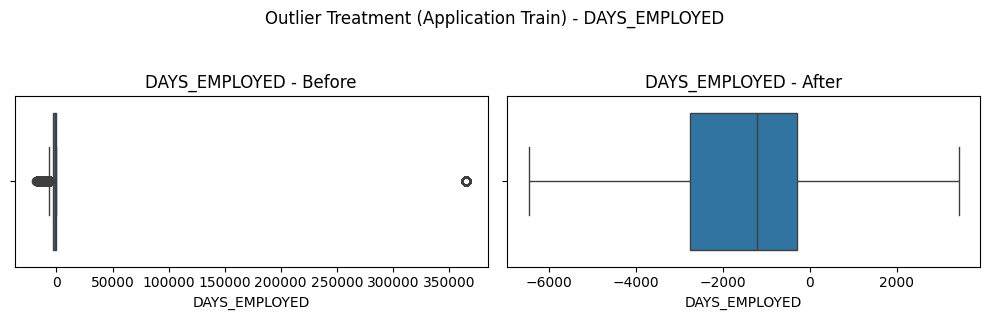


Outlier Treatment: Bureau
DAYS_CREDIT: Found 0 outliers


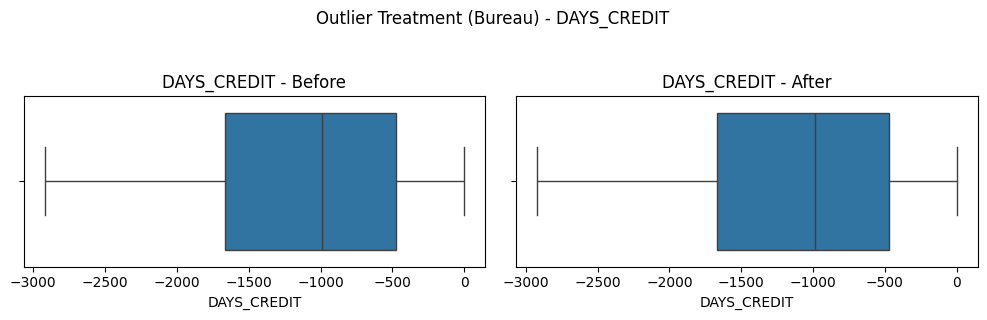

AMT_CREDIT_SUM: Found 187998 outliers


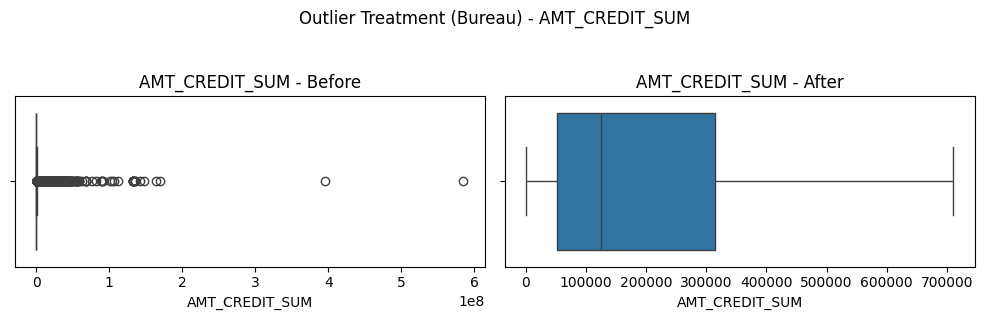

AMT_CREDIT_SUM_DEBT: Found 426105 outliers


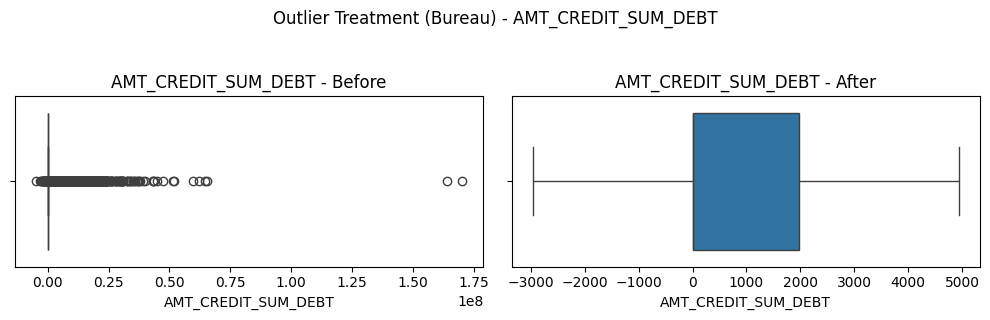


Outlier Treatment: Previous Application
AMT_CREDIT: Found 169806 outliers


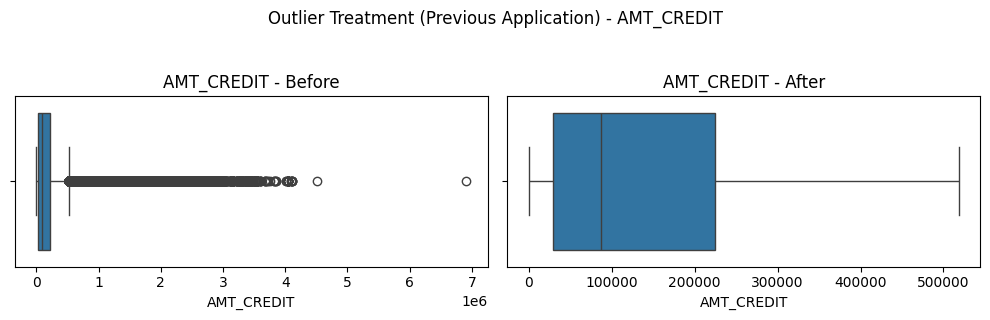

DAYS_DECISION: Found 0 outliers


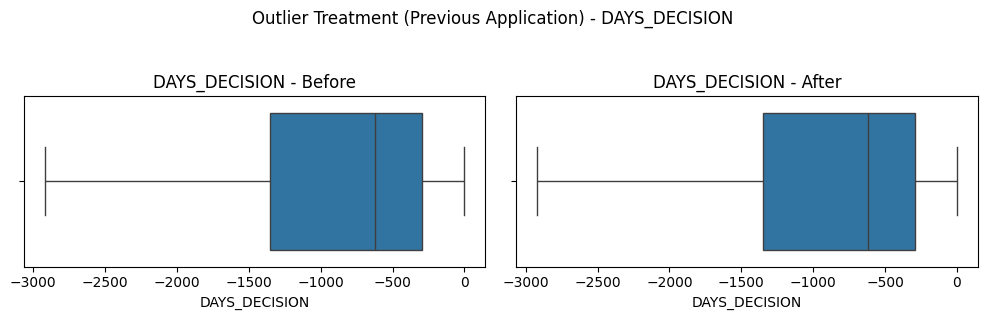


Outlier Treatment: Installments Payments
AMT_INSTALMENT: Found 1099958 outliers


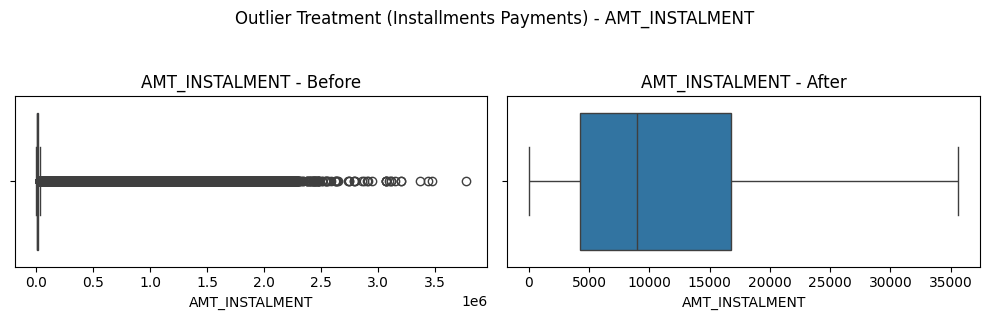

AMT_PAYMENT: Found 1111803 outliers


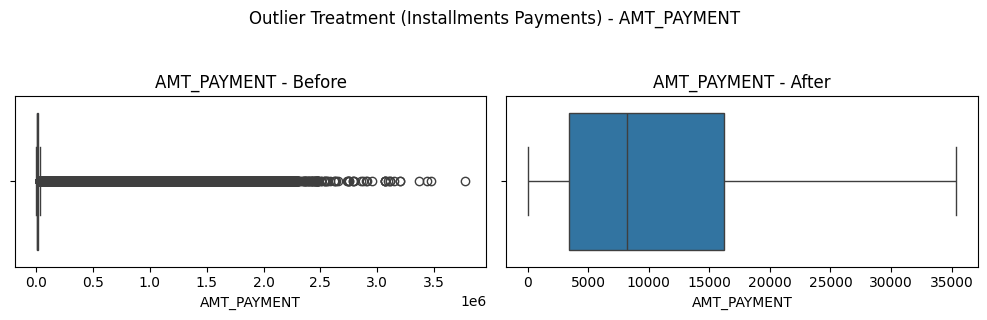

DAYS_ENTRY_PAYMENT: Found 1 outliers


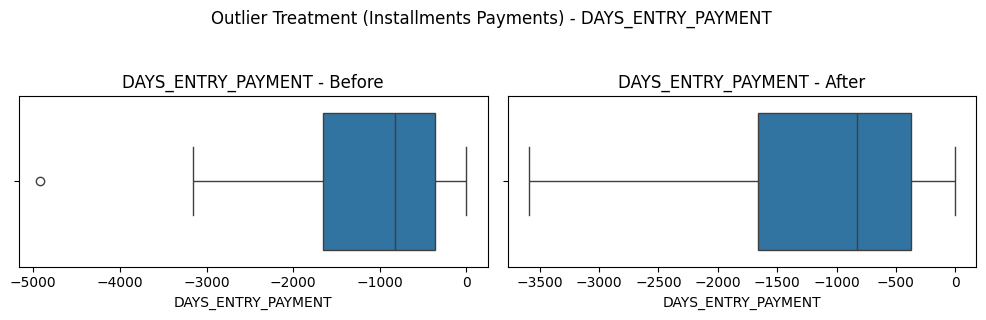

In [ ]:
application_train = treat_outliers(
    application_train,
    ['AMT_INCOME_TOTAL','AMT_CREDIT','AMT_ANNUITY','AMT_GOODS_PRICE','DAYS_EMPLOYED'],
    "Application Train"
)

bureau = treat_outliers(
    bureau,
    ['DAYS_CREDIT','AMT_CREDIT_SUM','AMT_CREDIT_SUM_DEBT'],
    "Bureau"
)

previous_application = treat_outliers(
    previous_application,
    ['AMT_CREDIT','AMT_ANNUITY','DAYS_DECISION'],
    "Previous Application"
)

installments_payments = treat_outliers(
    installments_payments,
    ['AMT_INSTALMENT','AMT_PAYMENT','DAYS_ENTRY_PAYMENT'],
    "Installments Payments"
)

# Feature Selection

In [ ]:
# Ambil hanya kolom numerik dari application_train
num_cols = application_train.select_dtypes(include=[np.number]).columns.tolist()

# Buat correlation matrix
corr_matrix = application_train[num_cols].corr()

# Ambil korelasi terhadap TARGET
target_corr = corr_matrix['TARGET'].sort_values(ascending=False)

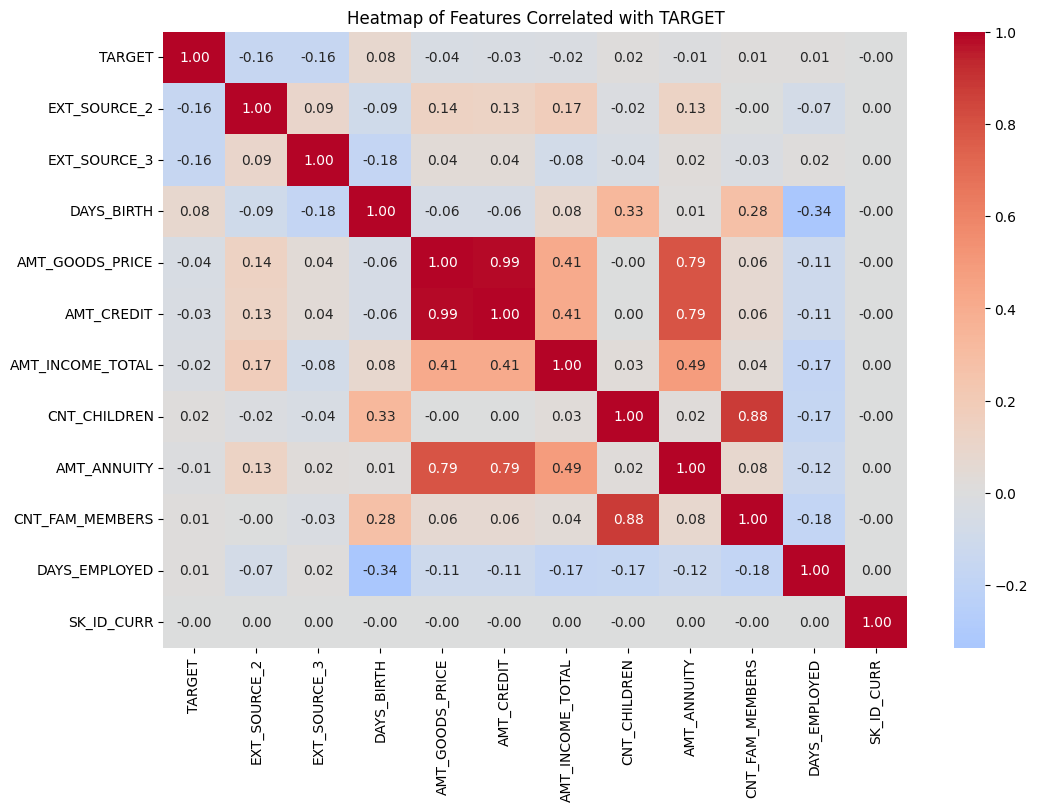

In [ ]:
#  Heatmap yang paling berkorelasi dengan TARGET
top_features = target_corr.abs().sort_values(ascending=False).head(21).index  # termasuk TARGET
plt.figure(figsize=(12,8))
sns.heatmap(application_train[top_features].corr(), cmap="coolwarm", center=0, annot=True, fmt=".2f")
plt.title("Heatmap of Features Correlated with TARGET")
plt.show()

1. bureau.csv : histori pinjaman di lembaga lain.
2. bureau_balance.csv : status bulanan pinjaman di bureau.
3. previous_application.csv : riwayat pengajuan pinjaman sebelumnya.
4. installments_payments.csv : histori pembayaran cicilan.
5. credit_card_balance.csv : performa kartu kredit bulanan.
6. POS_CASH_balance.csv → performa pinjaman POS/cash.

### Bureau

In [ ]:
bureau_agg = bureau.groupby("SK_ID_CURR").agg({
    "DAYS_CREDIT": ["mean","min","max"],
    "CREDIT_DAY_OVERDUE": ["mean","max"],
    "AMT_CREDIT_SUM": ["mean","sum"],
    "AMT_CREDIT_SUM_DEBT": ["mean","sum"]
}).reset_index()
bureau_agg.columns = ["SK_ID_CURR"] + ["BUREAU_" + "_".join(col).upper() for col in bureau_agg.columns[1:]]
application_train = application_train.merge(bureau_agg, on="SK_ID_CURR", how="left")
print("After Bureau merge:", application_train.shape)

After Bureau merge: (307511, 24)


### Bureau Balance

In [ ]:
bureau_balance

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C
3,5715448,-3,C
4,5715448,-4,C
...,...,...,...
27299920,5041336,-47,X
27299921,5041336,-48,X
27299922,5041336,-49,X
27299923,5041336,-50,X


In [ ]:
bureau_balance["STATUS_FLAG"] = bureau_balance["STATUS"].apply(lambda x: 1 if x in ["1","2","3","4","5"] else 0)

bb_agg = bureau_balance.groupby("SK_ID_BUREAU").agg({
    "MONTHS_BALANCE": ["min","max","mean"],
    "STATUS_FLAG": ["mean","sum"]
}).reset_index()
bb_agg.columns = ["SK_ID_BUREAU"] + ["BB_" + "_".join(col).upper() for col in bb_agg.columns[1:]]

bureau_bb = bureau.merge(bb_agg, on="SK_ID_BUREAU", how="left")
bureau_bb_agg = bureau_bb.groupby("SK_ID_CURR").agg({
    "BB_MONTHS_BALANCE_MIN": "mean",
    "BB_MONTHS_BALANCE_MAX": "mean",
    "BB_MONTHS_BALANCE_MEAN": "mean",
    "BB_STATUS_FLAG_MEAN": "mean",
    "BB_STATUS_FLAG_SUM": "mean"
}).reset_index()

application_train = application_train.merge(bureau_bb_agg, on="SK_ID_CURR", how="left")
print("After Bureau Balance merge:", application_train.shape)

After Bureau Balance merge: (307511, 29)


### Previous Application

In [ ]:
agg_dict = {}

if "AMT_CREDIT" in previous_application.columns:
    agg_dict["AMT_CREDIT"] = ["mean", "max"]

if "AMT_ANNUITY" in previous_application.columns:
    agg_dict["AMT_ANNUITY"] = ["mean", "max"]

if "DAYS_DECISION" in previous_application.columns:
    agg_dict["DAYS_DECISION"] = ["mean", "min", "max"]

if agg_dict:  # hanya jalan kalau ada kolom numerik valid
    prev_agg = previous_application.groupby("SK_ID_CURR").agg(agg_dict).reset_index()
    prev_agg.columns = ["SK_ID_CURR"] + ["PREV_" + "_".join(col).upper() for col in prev_agg.columns[1:]]

    application_train = application_train.merge(prev_agg, on="SK_ID_CURR", how="left")
    print("After Previous Application merge:", application_train.shape)
else:
    print("Tidak ada kolom numerik yang bisa diagregasi dari Previous Application")

After Previous Application merge: (307511, 34)


### Installments Payments

In [ ]:
inst_agg = installments_payments.groupby("SK_ID_CURR").agg({
    "AMT_INSTALMENT": ["mean","sum"],
    "AMT_PAYMENT": ["mean","sum"],
    "DAYS_ENTRY_PAYMENT": ["mean","min","max"]
}).reset_index()
inst_agg.columns = ["SK_ID_CURR"] + ["INST_" + "_".join(col).upper() for col in inst_agg.columns[1:]]
application_train = application_train.merge(inst_agg, on="SK_ID_CURR", how="left")
print("After Installments merge:", application_train.shape)

After Installments merge: (307511, 41)


### Credit Card Balance

In [ ]:
cc_agg = credit_card_balance.groupby("SK_ID_CURR").agg({
    "AMT_BALANCE": ["mean","max"],
    "AMT_CREDIT_LIMIT_ACTUAL": ["mean","max"],
    "AMT_DRAWINGS_CURRENT": ["mean","sum"],
    "SK_DPD": ["mean","max"]
}).reset_index()
cc_agg.columns = ["SK_ID_CURR"] + ["CC_" + "_".join(col).upper() for col in cc_agg.columns[1:]]
application_train = application_train.merge(cc_agg, on="SK_ID_CURR", how="left")
print("After Credit Card Balance merge:", application_train.shape)

After Credit Card Balance merge: (307511, 49)


### POS_CASH Balance

In [ ]:
pos_agg = pos_cash.groupby("SK_ID_CURR").agg({
    "MONTHS_BALANCE": ["mean","min","max"]
}).reset_index()
pos_agg.columns = ["SK_ID_CURR"] + ["POS_" + "_".join(col).upper() for col in pos_agg.columns[1:]]
application_train = application_train.merge(pos_agg, on="SK_ID_CURR", how="left")
print("After POS_CASH Balance merge:", application_train.shape)

After POS_CASH Balance merge: (307511, 52)


## Dataset Final

In [ ]:
application_train.shape

(307511, 52)

In [ ]:
application_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Data columns (total 52 columns):
 #   Column                           Non-Null Count   Dtype   
---  ------                           --------------   -----   
 0   SK_ID_CURR                       307511 non-null  int64   
 1   TARGET                           307511 non-null  int64   
 2   CODE_GENDER                      307511 non-null  category
 3   CNT_CHILDREN                     307511 non-null  int64   
 4   AMT_INCOME_TOTAL                 307511 non-null  float64 
 5   AMT_CREDIT                       307511 non-null  float64 
 6   AMT_ANNUITY                      307511 non-null  float64 
 7   AMT_GOODS_PRICE                  307511 non-null  float64 
 8   NAME_EDUCATION_TYPE              307511 non-null  category
 9   NAME_FAMILY_STATUS               307511 non-null  category
 10  DAYS_BIRTH                       307511 non-null  int64   
 11  DAYS_EMPLOYED                    307511 non-null  fl

In [ ]:
X = application_train.drop(columns=['TARGET','SK_ID_CURR'])
y = application_train['TARGET']

## Multicollinearity Check (VIF Analysis)

In [ ]:
# Ambil numerik
X_num = X.select_dtypes(include=[np.number])

# Ganti inf dengan NaN lalu isi NaN dengan median
X_num = X_num.replace([np.inf, -np.inf], np.nan)
X_num = X_num.fillna(X_num.median())

# Hitung VIF
vif_data = pd.DataFrame()
vif_data["Feature"] = X_num.columns
vif_data["VIF"] = [variance_inflation_factor(X_num.values, i) for i in range(X_num.shape[1])]

print("\nTop VIF Features:")
print(vif_data.sort_values(by="VIF", ascending=False).head(30))


Top VIF Features:
                            Feature          VIF
21           BB_MONTHS_BALANCE_MEAN  1133.501844
19            BB_MONTHS_BALANCE_MIN   800.749563
29         INST_AMT_INSTALMENT_MEAN   261.193701
32             INST_AMT_PAYMENT_SUM   259.333109
30          INST_AMT_INSTALMENT_SUM   256.737155
31            INST_AMT_PAYMENT_MEAN   252.643167
44          POS_MONTHS_BALANCE_MEAN   128.606127
4                   AMT_GOODS_PRICE   122.062139
2                        AMT_CREDIT   119.621334
45           POS_MONTHS_BALANCE_MIN   116.528881
34      INST_DAYS_ENTRY_PAYMENT_MIN    97.874482
33     INST_DAYS_ENTRY_PAYMENT_MEAN    79.933310
10          BUREAU_DAYS_CREDIT_MEAN    64.325075
27           PREV_DAYS_DECISION_MIN    53.415397
39   CC_AMT_CREDIT_LIMIT_ACTUAL_MAX    51.534564
38  CC_AMT_CREDIT_LIMIT_ACTUAL_MEAN    49.473108
26          PREV_DAYS_DECISION_MEAN    48.269470
11           BUREAU_DAYS_CREDIT_MIN    45.067048
20            BB_MONTHS_BALANCE_MAX    35.222326
3

In [ ]:
drop_cols_vif = [
    "BB_MONTHS_BALANCE_MIN",
    "BB_MONTHS_BALANCE_MAX",
    "POS_MONTHS_BALANCE_MIN",
    "POS_MONTHS_BALANCE_MAX",
    "INST_AMT_INSTALMENT_MEAN",
    "INST_AMT_PAYMENT_MEAN",
    "CC_AMT_CREDIT_LIMIT_ACTUAL_MAX",
    "CC_AMT_BALANCE_MAX",
    "CC_SK_DPD_MAX",
    "BUREAU_DAYS_CREDIT_MIN",
    "PREV_DAYS_DECISION_MIN"
]

X = X.drop(columns=[c for c in drop_cols_vif if c in X.columns])
print("Shape setelah drop redundant VIF cols:", X.shape)
print("Columns dropped:", [c for c in drop_cols_vif if c not in X.columns])

Shape setelah drop redundant VIF cols: (307511, 39)
Columns dropped: ['BB_MONTHS_BALANCE_MIN', 'BB_MONTHS_BALANCE_MAX', 'POS_MONTHS_BALANCE_MIN', 'POS_MONTHS_BALANCE_MAX', 'INST_AMT_INSTALMENT_MEAN', 'INST_AMT_PAYMENT_MEAN', 'CC_AMT_CREDIT_LIMIT_ACTUAL_MAX', 'CC_AMT_BALANCE_MAX', 'CC_SK_DPD_MAX', 'BUREAU_DAYS_CREDIT_MIN', 'PREV_DAYS_DECISION_MIN']


# Ambil subset data

In [ ]:
X, _, y, _ = train_test_split(
    X, y,
    test_size=0.8,       # ambil 20% saja biar ringan
    stratify=y,
    random_state=42
)

print("Subset shape:", X.shape, y.shape)
print("Distribusi target di subset:")
print(y.value_counts(normalize=True).round(3))

Subset shape: (61502, 39) (61502,)
Distribusi target di subset:
TARGET
0    0.919
1    0.081
Name: proportion, dtype: float64


# Split Data

In [ ]:
X_trainval, X_test, y_trainval, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval, test_size=0.25, stratify=y_trainval, random_state=42
)

print("Train:", X_train.shape, "Validation:", X_val.shape, "Test:", X_test.shape)

Train: (36900, 39) Validation: (12301, 39) Test: (12301, 39)


# Preprocessing Data Training

In [ ]:
num_cols = X_train.select_dtypes(include=['float64','int64']).columns.tolist()
cat_cols = X_train.select_dtypes(include=['object','category','bool']).columns.tolist()

num_imputer = SimpleImputer(strategy="median")
cat_imputer = SimpleImputer(strategy="most_frequent")

## Imputasi numerik & kategorikal

In [ ]:
X_train[num_cols] = num_imputer.fit_transform(X_train[num_cols])
X_val[num_cols]   = num_imputer.transform(X_val[num_cols])
X_test[num_cols]  = num_imputer.transform(X_test[num_cols])

X_train[cat_cols] = cat_imputer.fit_transform(X_train[cat_cols])
X_val[cat_cols]   = cat_imputer.transform(X_val[cat_cols])
X_test[cat_cols]  = cat_imputer.transform(X_test[cat_cols])

## Encoding Kolom Kategori

In [ ]:
X_train = pd.get_dummies(X_train, columns=cat_cols, drop_first=True)
X_val   = pd.get_dummies(X_val,   columns=cat_cols, drop_first=True)
X_test  = pd.get_dummies(X_test,  columns=cat_cols, drop_first=True)

In [ ]:
X_val  = X_val.reindex(columns=X_train.columns, fill_value=0)
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

print("Final shapes:", X_train.shape, X_val.shape, X_test.shape)

Final shapes: (36900, 46) (12301, 46) (12301, 46)


# Modelling

In [ ]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
smote_clean = SMOTEENN(random_state=42)

## Logistic Regression (Baseline + Tuned)

In [ ]:
scaler = StandardScaler()

log_reg_smote = ImbPipeline(steps=[
    ('scaler', scaler),
    ('smote', smote_clean),
    ('clf', LogisticRegression(max_iter=500, solver='lbfgs', random_state=42))
])

param_dist_lr = {
    'clf__C': np.logspace(-3, 3, 7),
    'clf__penalty': ['l2'],
    'clf__solver': ['lbfgs', 'liblinear']
}

rand_lr = RandomizedSearchCV(
    log_reg_smote, param_distributions=param_dist_lr, n_iter=5,
    scoring='roc_auc', cv=cv, n_jobs=-1, random_state=42, verbose=1
)
rand_lr.fit(X_train, y_train)
best_lr_model = rand_lr.best_estimator_

Fitting 5 folds for each of 5 candidates, totalling 25 fits


## Random Forest (Baseline + Tuned)

In [ ]:
rf_model_smote = ImbPipeline(steps=[
    ('smote', smote_clean),
    ('clf', RandomForestClassifier(random_state=42, n_jobs=-1))
])

param_dist_rf = {
    'clf__n_estimators': [100, 200, 300],
    'clf__max_depth': [5, 10, None],
    'clf__min_samples_split': [2, 5, 10],
    'clf__min_samples_leaf': [1, 2, 4]
}

rand_rf = RandomizedSearchCV(
    rf_model_smote, param_distributions=param_dist_rf, n_iter=5,
    scoring='roc_auc', cv=cv, n_jobs=-1, random_state=42, verbose=1
)
rand_rf.fit(X_train, y_train)
best_rf_model = rand_rf.best_estimator_

Fitting 5 folds for each of 5 candidates, totalling 25 fits


## LightGBM (Baseline + Tuned)

In [ ]:
lgb_model_smote = ImbPipeline(steps=[
    ('smote', smote_clean),
    ('clf', lgb.LGBMClassifier(random_state=42, n_jobs=-1))
])

param_dist_lgb = {
    'clf__num_leaves': [31, 63, 127],
    'clf__learning_rate': [0.1, 0.05, 0.01],
    'clf__n_estimators': [100, 200, 300],
    'clf__max_depth': [5, 10, -1],
    'clf__reg_alpha': [0, 0.1, 1],
    'clf__reg_lambda': [0, 0.1, 1],
    'clf__subsample': [0.7, 0.8, 1.0],
    'clf__colsample_bytree': [0.7, 0.8, 1.0]
}

rand_lgb = RandomizedSearchCV(
    lgb_model_smote, param_distributions=param_dist_lgb, n_iter=5,
    scoring='roc_auc', cv=cv, n_jobs=-1, random_state=42, verbose=1
)
rand_lgb.fit(X_train, y_train)
best_lgb_model = rand_lgb.best_estimator_

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 32634, number of negative: 20748
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.026088 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9194
[LightGBM] [Info] Number of data points in the train set: 53382, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.611330 -> initscore=0.452905
[LightGBM] [Info] Start training from score 0.452905


## XGBoost (Baseline + Tuned)

In [ ]:
import xgboost as xgb

# Baseline XGBoost
xgb_model_smote = ImbPipeline(steps=[
    ('smote', smote_clean),
    ('clf', xgb.XGBClassifier(
        objective="binary:logistic",
        eval_metric="auc",
        use_label_encoder=False,
        random_state=42,
        n_jobs=-1
    ))
])

# Hyperparameter tuning XGBoost
param_dist_xgb = {
    'clf__n_estimators': [100, 200, 300],
    'clf__max_depth': [3, 5, 7, 10],
    'clf__learning_rate': [0.1, 0.05, 0.01],
    'clf__subsample': [0.7, 0.8, 1.0],
    'clf__colsample_bytree': [0.7, 0.8, 1.0],
    'clf__gamma': [0, 0.1, 0.5, 1],
    'clf__scale_pos_weight': [1, 5, 10]  # penting untuk imbalance
}

rand_xgb = RandomizedSearchCV(
    xgb_model_smote,
    param_distributions=param_dist_xgb,
    n_iter=10,
    scoring='roc_auc',
    cv=cv,
    n_jobs=-1,
    random_state=42,
    verbose=1
)

rand_xgb.fit(X_train, y_train)
best_xgb_model = rand_xgb.best_estimator_

Fitting 5 folds for each of 10 candidates, totalling 50 fits


## Evaluasi Model (6 Model: Baseline & Tuned)

In [ ]:
models = {
    "LogReg (Default)": log_reg_smote,
    "LogReg (Tuned)": best_lr_model,
    "RF (Default)": rf_model_smote,
    "RF (Tuned)": best_rf_model,
    "LGBM (Default)": lgb_model_smote,
    "LGBM (Tuned)": best_lgb_model,
    "XGB (Default)": xgb_model_smote,
    "XGB (Tuned)": best_xgb_model
}

In [ ]:
for name, model in models.items():
    print("\n" + "="*70)
    print(f"🔹 {name} - Validation Set")
    print("="*70)

    model.fit(X_train, y_train)
    y_pred_val = model.predict(X_val)
    y_proba_val = model.predict_proba(X_val)[:, 1]

    print(classification_report(y_val, y_pred_val, digits=4))
    print("ROC AUC (Validation):", roc_auc_score(y_val, y_proba_val))


🔹 LogReg (Default) - Validation Set
              precision    recall  f1-score   support

           0     0.9670    0.4920    0.6521     11308
           1     0.1226    0.8087    0.2130       993

    accuracy                         0.5175     12301
   macro avg     0.5448    0.6503    0.4325     12301
weighted avg     0.8988    0.5175    0.6167     12301

ROC AUC (Validation): 0.7279765397043543

🔹 LogReg (Tuned) - Validation Set
              precision    recall  f1-score   support

           0     0.9670    0.4916    0.6518     11308
           1     0.1226    0.8087    0.2129       993

    accuracy                         0.5172     12301
   macro avg     0.5448    0.6501    0.4323     12301
weighted avg     0.8988    0.5172    0.6164     12301

ROC AUC (Validation): 0.728122324969516

🔹 RF (Default) - Validation Set
              precision    recall  f1-score   support

           0     0.9287    0.9432    0.9359     11308
           1     0.2132    0.1752    0.1924       9

## Visualisasi Recall per Model & Target Class

In [ ]:
# Simpan recall tiap model untuk target 0 & 1
recall_results = []

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred_val = model.predict(X_val)

    recall_0 = recall_score(y_val, y_pred_val, pos_label=0)
    recall_1 = recall_score(y_val, y_pred_val, pos_label=1)

    recall_results.append({"Model": name, "Target": "0 (Tepat Bayar)", "Recall": recall_0})
    recall_results.append({"Model": name, "Target": "1 (Gagal Bayar)", "Recall": recall_1})

recall_df = pd.DataFrame(recall_results)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 32634, number of negative: 20748
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.117431 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9194
[LightGBM] [Info] Number of data points in the train set: 53382, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.611330 -> initscore=0.452905
[LightGBM] [Info] Start training from score 0.452905
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 32634, number of negative: 20748
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011835 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col

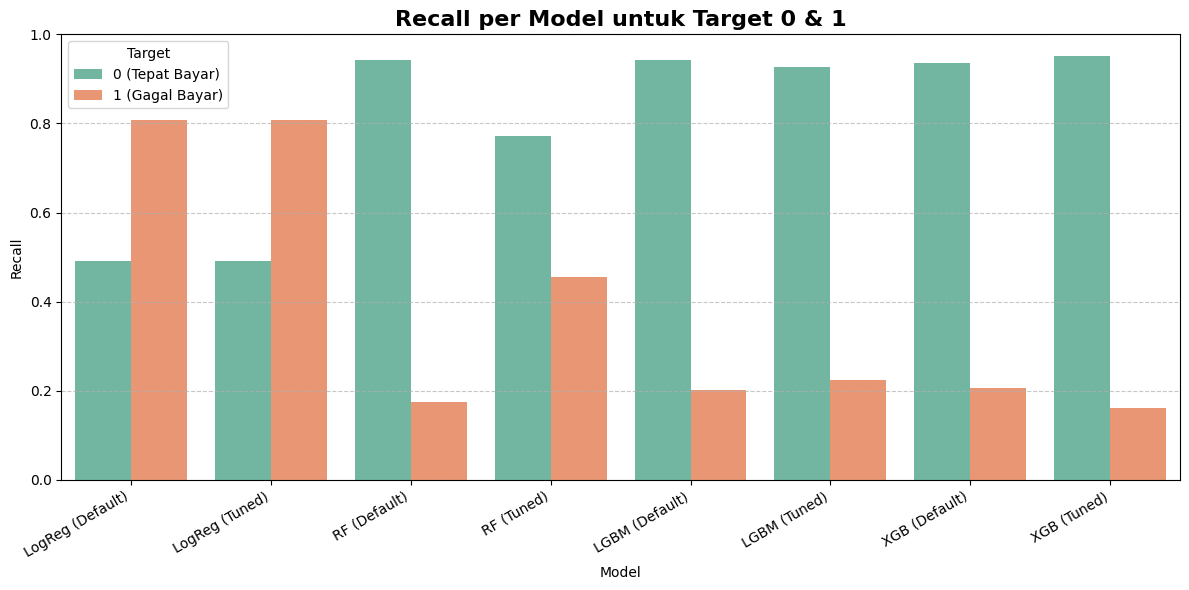

In [ ]:
plt.figure(figsize=(12,6))
sns.barplot(
    data=recall_df,
    x="Model", y="Recall", hue="Target",
    palette="Set2"
)
plt.title("Recall per Model untuk Target 0 & 1", fontsize=16, weight="bold")
plt.xticks(rotation=30, ha="right")
plt.ylim(0,1)
plt.legend(title="Target")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

## Pilih Best Model

In [ ]:
best_models = {
    "RF (Tuned)": best_rf_model,
    "LGBM (Tuned)": best_lgb_model
}

# Evaluasi Model pada Test Set


🔹 RF (Tuned) - Test Set
              precision    recall  f1-score   support

           0     0.9427    0.7730    0.8495     11308
           1     0.1525    0.4653    0.2297       993

    accuracy                         0.7482     12301
   macro avg     0.5476    0.6191    0.5396     12301
weighted avg     0.8789    0.7482    0.7994     12301

ROC AUC (Test): 0.6876411320702291
Confusion Matrix:
 [[8741 2567]
 [ 531  462]]


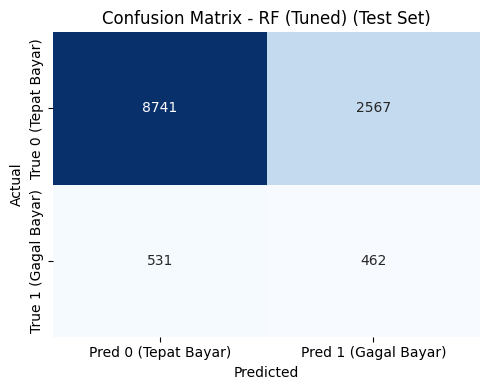


🔹 LGBM (Tuned) - Test Set
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 32634, number of negative: 20748
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012070 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9194
[LightGBM] [Info] Number of data points in the train set: 53382, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.611330 -> initscore=0.452905
[LightGBM] [Info] Start training from score 0.452905
              precision    recall  f1-score   support

           0     0.9314    0.9287    0.9301     11308
           1     0.2144    0.2216    0.2179       993

    accuracy                         0.8716     12301
   macro avg     0.5729    0.5751    0.5740     12301
weighted avg     0.8736    0.8716    0.8726     12301

ROC AUC (T

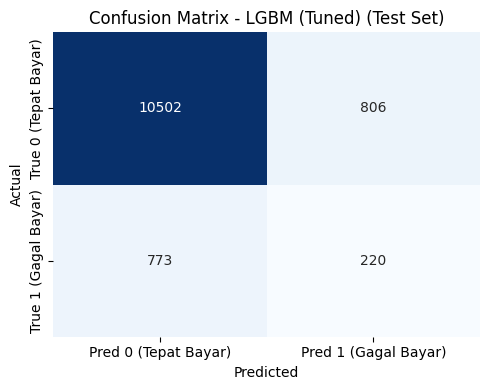

In [ ]:
for name, model in best_models.items():
    print("\n" + "="*70)
    print(f"🔹 {name} - Test Set")
    print("="*70)

    # Fit model pada train
    model.fit(X_train, y_train)

    # Prediksi pada test
    y_pred_test = model.predict(X_test)
    y_proba_test = model.predict_proba(X_test)[:, 1]

    # Classification report
    print(classification_report(y_test, y_pred_test, digits=4))

    # ROC AUC
    print("ROC AUC (Test):", roc_auc_score(y_test, y_proba_test))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred_test)
    print("Confusion Matrix:\n", cm)

    # Heatmap Confusion Matrix (dipisah per model)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
                xticklabels=["Pred 0 (Tepat Bayar)","Pred 1 (Gagal Bayar)"],
                yticklabels=["True 0 (Tepat Bayar)","True 1 (Gagal Bayar)"])
    plt.title(f"Confusion Matrix - {name} (Test Set)")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()

# Feature Importance / Coefficients


🔹 Feature Importance - RF (Tuned)
                                              Feature  Importance
8                                        EXT_SOURCE_2    0.108248
41  NAME_EDUCATION_TYPE_Secondary / secondary special    0.102071
7                                     CNT_FAM_MEMBERS    0.087774
36                                      CODE_GENDER_M    0.075193
9                                        EXT_SOURCE_3    0.072236
6                                       DAYS_EMPLOYED    0.068744
17                     BUREAU_AMT_CREDIT_SUM_DEBT_SUM    0.068131
0                                        CNT_CHILDREN    0.064402
16                    BUREAU_AMT_CREDIT_SUM_DEBT_MEAN    0.035787
38               NAME_EDUCATION_TYPE_Higher education    0.034198
44            NAME_FAMILY_STATUS_Single / not married    0.027129
5                                          DAYS_BIRTH    0.019131
28                        INST_DAYS_ENTRY_PAYMENT_MIN    0.018806
32                       CC_AMT_DRAWINGS_

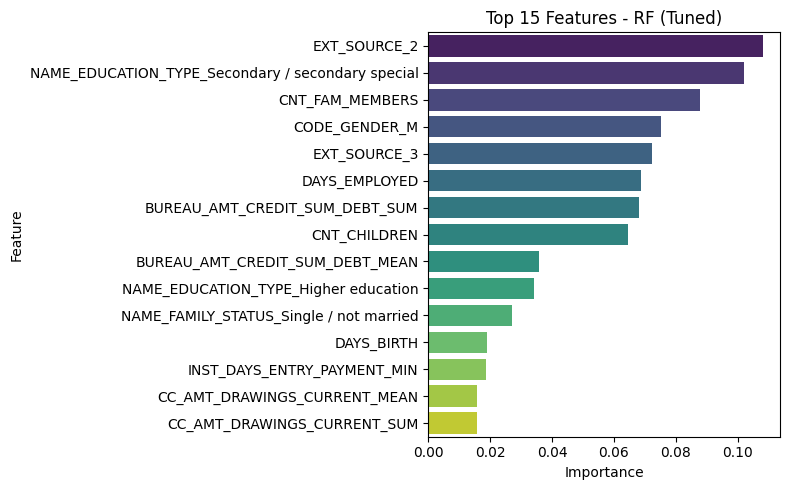


🔹 Feature Importance - LGBM (Tuned)
                            Feature  Importance
0                      CNT_CHILDREN         380
17   BUREAU_AMT_CREDIT_SUM_DEBT_SUM         380
1                  AMT_INCOME_TOTAL         378
7                   CNT_FAM_MEMBERS         371
6                     DAYS_EMPLOYED         334
8                      EXT_SOURCE_2         290
9                      EXT_SOURCE_3         282
15        BUREAU_AMT_CREDIT_SUM_SUM         228
4                   AMT_GOODS_PRICE         223
26             INST_AMT_PAYMENT_SUM         213
16  BUREAU_AMT_CREDIT_SUM_DEBT_MEAN         183
2                        AMT_CREDIT         168
5                        DAYS_BIRTH         165
29      INST_DAYS_ENTRY_PAYMENT_MAX         160
3                       AMT_ANNUITY         152


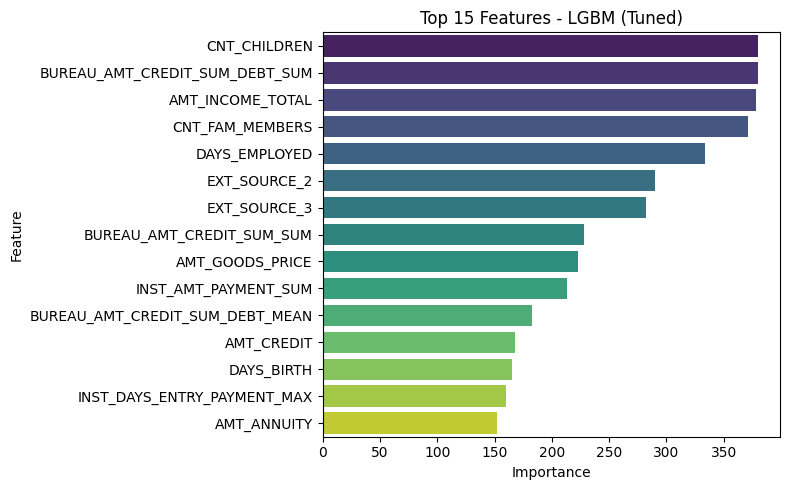

In [ ]:
for name, model in best_models.items():
    print("\n" + "="*70)
    print(f"🔹 Feature Importance - {name}")
    print("="*70)

    # Ambil estimator terakhir dari pipeline (clf)
    clf = model.named_steps["clf"]

    if hasattr(clf, "feature_importances_"):
        # Tree-based models (RF, LGBM)
        feat_imp = pd.DataFrame({
            "Feature": X_train.columns,
            "Importance": clf.feature_importances_
        }).sort_values(by="Importance", ascending=False)

    elif hasattr(clf, "coef_"):
        # Linear models (LogReg)
        feat_imp = pd.DataFrame({
            "Feature": X_train.columns,
            "Coefficient": clf.coef_[0]
        }).sort_values(by="Coefficient", ascending=False)

    else:
        print("Model ini tidak punya feature_importances_ atau coef_.")
        continue

    print(feat_imp.head(15))  # print 15 fitur teratas
      # Visualisasi Top 15
    plt.figure(figsize=(8,5))
    sns.barplot(data=feat_imp.head(15), x="Importance" if "Importance" in feat_imp else "Coefficient",
                y="Feature", palette="viridis")
    plt.title(f"Top 15 Features - {name}")
    plt.tight_layout()
    plt.show()

## Rekomendasi Bisnis

Rekomendasi Bisnis
- Fokus pada Pendapatan: <br>
Pendapatan (AMT_INCOME_TOTAL) adalah faktor terpenting. Gunakan pendapatan sebagai dasar utama untuk menyesuaikan jumlah pinjaman dan syarat pembayaran.
- Prioritaskan Riwayat Keuangan: <br>
Riwayat utang di lembaga lain (BUREAU_AMT_CREDIT_SUM_DEBT_SUM) dan riwayat pembayaran cicilan (POS_MONTHS_BALANCE_MAX) memiliki pengaruh besar pada risiko.
- Manfaatkan Informasi Demografi: <br>
Gunakan data usia (DAYS_BIRTH), status keluarga, dan pendidikan untuk membuat kebijakan pinjaman yang lebih terperinci dan otomatis.
- Otomatisasi Keputusan: <br>
Gunakan skor risiko dari model LightGBM untuk membuat sistem yang secara otomatis menyetujui, menolak, atau merujuk aplikasi pinjaman.
- Optimalisasi Produk: <br>
Kembangkan produk pinjaman dengan principal, maturity, dan repayment calendar yang disesuaikan berdasarkan skor risiko, untuk mendorong nasabah sukses dalam membayar kembali pinjaman mereka.